**CONSIGNAS PARA TODOS LOS EJERCICIOS:**

1.   En el caso de utilizar una Regresión Logística grafique sus parámetros con la función AA_utils.visualizar_parametros
2.   Grafique e interprete la matriz de confusión de la predicción sobre el set de test con la función AA_utils.visualizar_confusion_matrix
3.   Elabore un reporte de métricas tanto para la predicción de train como para la de test con la función AA_utils.print_classification_report
4.   En los casos de clasificación binaria grafique e interprete la curva ROC con la función AA_utils.visualizar_curva_ROC
5.   En los caso de clasificación de dos variables grafique la función de transferencia y la frontera de decisión con las funciones AA_utils.visualizar_funcion_transferencia_2D y AA_utils.visualizar_frontera_de_desicion_2D
6.   En los casos de clasificación binaria de una variable grafique la curva logística con la función AA_utils.visualizar_curva_logistica

# **DIABETES**

Clasificación Binaria: Compare modelos de Regresión Logística y Redes Neuronales para el siguiente dataset:
*   Diabetes.csv. El archivo posee 2000 registros con información de análisis clínicos de pacientes, indicando si poseen o no diabetes gestacional.

El código “ejemplo_clasificacion_binaria_dos_variables_red_neuronal.py” posee un ejemplo de cómo realizar esta tarea.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import LogisticRegression

# **AA UTILS**

In [2]:
def if_dataframe_to_numpy(data):
    return data.to_numpy() if isinstance(data, pd.DataFrame) or isinstance(data, pd.Series) else data

def plot_2d(modelo, X, X_train, X_test, y_train, y_test, boundry_function):

    assert X.shape[1] == 2, f"X debe tener solo dos variables de entrada (tiene {X.shape[1]})"

    X = if_dataframe_to_numpy(X)
    X_train = if_dataframe_to_numpy(X_train)
    X_test = if_dataframe_to_numpy(X_test)

    plt.figure()
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    Z = np.c_[xx.ravel(), yy.ravel()]
    Z = boundry_function(modelo, Z)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.colorbar()

    plt.scatter(X_train[:, 0], X_train[:, 1], marker="o", c=y_train, label='Training')
    plt.scatter(X_test[:, 0], X_test[:, 1], marker="+", c=y_test, s=80, label='Testing')
    plt.legend()
    plt.show()

def print_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))

def visualizar_parametros(modelo, mostrar_bias, feature_names=[], target_name='target'):
    parametros = pd.DataFrame(modelo.coef_, columns=feature_names if len(feature_names) > 0 else range(modelo.coef_.shape[1]))

    if mostrar_bias:
        parametros['bias'] = modelo.intercept_

    parametros.T.plot(kind='bar')

    if hasattr(modelo, 'classes_'):
        if len(modelo.classes_) <= 2:
            plt.legend([target_name])
        else:
            plt.legend(list(modelo.classes_))
    else:
        plt.legend([target_name])

    plt.show()

def visualizar_curva_logistica(modelo, X, y, feature_name='target'):

    assert X.shape[1] == 1, f"X debe tener solo una variable de entrada (tiene {X.shape[1]})"

    X = if_dataframe_to_numpy(X)

    plt.figure()
    plt.scatter(X, y, c=y, s=50)
    plt.xlabel(feature_name)
    plt.grid()

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x_graph = np.linspace(x_min, x_max)
    y_graph = modelo.predict_proba(x_graph.reshape(-1, 1))[:, 1]
    plt.plot(x_graph, y_graph)
    plt.show()

def visualizar_frontera_de_desicion_2D(modelo, X, X_train, X_test, y_train, y_test):
    plot_2d(modelo, X, X_train, X_test, y_train, y_test, lambda modelo, Z: modelo.predict(Z))

def visualizar_funcion_transferencia_2D(modelo, X, X_train, X_test, y_train, y_test):

    if hasattr(modelo, 'predict_proba') and callable(getattr(modelo, 'predict_proba')):
        plot_2d(modelo, X, X_train, X_test, y_train, y_test, lambda modelo, Z: modelo.predict_proba(Z)[:, 1])
    else:
        raise ValueError("no se puede visualizar funcion de transferencia")

def visualizar_confusion_matrix(real_target, pred_target,
                                classes=[],
                                normalize=False,
                                title='Matriz de confusión',
                                cmap=plt.cm.Blues):

    if (len(classes) == 0):
        classes = [str(i) for i in range(int(max(real_target) + 1))]  # nombres de clases consecutivos

    cm = confusion_matrix(real_target, pred_target)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", size=16)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def visualizar_curva_ROC(modelo, X, y):

    assert len(set(y)) <= 2, f"El dataset debe ser binario (hay {len(set(y))}) clases"

    y_score = modelo.predict_proba(X)[:, 1]  # se queda con la clase 1

    false_positive_rate, true_positive_rate, threshold = roc_curve(y, y_score)

    precision, recall, _ = precision_recall_curve(y, y_score)

    # ROC
    plt.figure()
    plt.title('ROC. Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc_score(y, y_score))
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0], c=".7"), plt.plot([1, 1], c=".7")
    plt.legend(loc="lower right")
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlabel('False Positive Rate (1- Especificidad)')
    plt.show()

    # precision-recall curve
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve')
    plt.show()

def elegir_imagen_al_azar(X, pixeles_ancho, pixeles_alto):
    indice = np.random.randint(0, X.shape[0])
    img_i = np.reshape(X[indice, :], (pixeles_ancho, pixeles_alto))
    plt.figure()
    plt.imshow(img_i, 'gray')
    plt.title('Dato aleatorio')
    plt.show()
    return X[indice].reshape(1, -1), indice

def visualizar_parametros_para_imagenes(modelo, cantidad_de_clases, pixeles_ancho=28, pixeles_alto=28):

    if hasattr(modelo, 'coef_'):
        w = modelo.coef_
    elif hasattr(modelo, 'coefs_') and (modelo.coefs_) == 1:
        w = modelo.coefs_[0]
    else:
        raise "para visualizar los parametros de la red es necesario tener cero capas ocultas"

    colorbar_max = np.abs(np.max(w))
    w_r = np.reshape(w, (cantidad_de_clases, pixeles_ancho, pixeles_alto))
    fig, ax = plt.subplots(2, cantidad_de_clases // 2)
    plt.suptitle('Coeficientes aprendidos para cada clase, \nagrupados en forma matricial de 28x28')
    index = 0
    for row in range(0, 2):
        for col in range(0, cantidad_de_clases // 2):
            colorbar_max = max(np.abs(np.max(w_r[index, :, :])), np.abs(np.min(w_r[index, :, :])))
            ax_im = ax[row][col].imshow(w_r[index, :, :], cmap='seismic', vmin=-colorbar_max, vmax=colorbar_max)
            ax[row][col].get_xaxis().set_visible(False)
            ax[row][col].get_yaxis().set_visible(False)
            ax[row][col].set_title(str(index))
            divider = make_axes_locatable(ax[row][col])
            cax = divider.append_axes("right", size="5%", pad=0.05)

            fig.colorbar(ax_im, ax=ax[row][col], cax=cax)
            index += 1
    plt.show()

def visualizar_ajuste_por_regresion(modelo, X_train, X_test, y_train, y_test,
                                    feature_name='X', target_name='target'):
    plt.scatter(X_train, y_train, c='blue', s=40, alpha=0.9, label='Training')
    plt.scatter(X_test, y_test, c='red', s=50, alpha=0.5, label='Testing')
    plt.xlabel(feature_name)
    plt.ylabel(target_name)
    plt.legend()
    plt.grid()

    X_train = if_dataframe_to_numpy(X_train)
    X_test = if_dataframe_to_numpy(X_test)

    x_max = max(max(X_train), max(X_test))
    x_min = min(min(X_train), min(X_test))

    x_plot = np.linspace(x_min, x_max, 100)
    y_plot = modelo.predict(x_plot.reshape(-1, 1))
    plt.plot(x_plot, y_plot, 'g--', linewidth=5)
    plt.show()

def visualizar_curva_error_entrenamiento(modelo):
    plt.plot(modelo.loss_curve_)
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.legend(['Train'])
    plt.show()


# **CARGA DE DATOS**

In [3]:
data = pd.read_csv(r"https://raw.githubusercontent.com/KevinFDI/IML_Practica_3/main/Pr%C3%A1ctica/datasets/diabetes.csv")

In [4]:
pd.DataFrame(data)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Clase
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0
...,...,...,...,...,...,...,...,...,...
1995,2,75,64,24,55,29.7,0.370,33,0
1996,8,179,72,42,130,32.7,0.719,36,1
1997,6,85,78,0,0,31.2,0.382,42,0
1998,0,129,110,46,130,67.1,0.319,26,1


**PREPROCESADO**

In [5]:
X = data.drop(columns=['Clase'])
y = data['Clase']

print(f'''
      ====================================================================================================
      El problema de clasificación es de {X.shape[1]} features ---(prediciendo)---> {len(set(y))} clases
      ====================================================================================================
      ''')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

NORMALIZAR = True

if NORMALIZAR:
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)


      El problema de clasificación es de 8 features ---(prediciendo)---> 2 clases
      


# **REDES NEURONALES**

**MODELADO**

In [6]:
modelo = MLPClassifier(hidden_layer_sizes=(20, 5),
                       max_iter=500,
                       tol=1e-4,
                       verbose=True,
                       activation='tanh',
                       learning_rate_init=0.003,
                       solver='adam')
modelo.fit(X_train, y_train)

Iteration 1, loss = 0.59415871
Iteration 2, loss = 0.53401094
Iteration 3, loss = 0.50591589
Iteration 4, loss = 0.48872266
Iteration 5, loss = 0.47799727
Iteration 6, loss = 0.47074258
Iteration 7, loss = 0.46546451
Iteration 8, loss = 0.46138232
Iteration 9, loss = 0.45770143
Iteration 10, loss = 0.45467492
Iteration 11, loss = 0.45255489
Iteration 12, loss = 0.44938220
Iteration 13, loss = 0.44715911
Iteration 14, loss = 0.44466299
Iteration 15, loss = 0.44257057
Iteration 16, loss = 0.44005772
Iteration 17, loss = 0.43794868
Iteration 18, loss = 0.43543316
Iteration 19, loss = 0.43374322
Iteration 20, loss = 0.43068807
Iteration 21, loss = 0.42861577
Iteration 22, loss = 0.42650612
Iteration 23, loss = 0.42432834
Iteration 24, loss = 0.42230614
Iteration 25, loss = 0.42068382
Iteration 26, loss = 0.41868658
Iteration 27, loss = 0.41694534
Iteration 28, loss = 0.41504250
Iteration 29, loss = 0.41331238
Iteration 30, loss = 0.41162270
Iteration 31, loss = 0.41029863
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 5),
              learning_rate_init=0.003, max_iter=500, verbose=True)

**EVALUACION**

**MÉTRICAS SOBRE EL CONJUNTO DE TRAINING**

In [7]:
# 3

print_classification_report(y_train, modelo.predict(X_train))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1055
           1       0.98      0.94      0.96       545

    accuracy                           0.97      1600
   macro avg       0.97      0.96      0.97      1600
weighted avg       0.97      0.97      0.97      1600



MÉTRICAS SOBRE EL CONJUNTO DE TESTING

In [8]:
# 3

print_classification_report(y_test, modelo.predict(X_test))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       261
           1       0.95      0.84      0.89       139

    accuracy                           0.93       400
   macro avg       0.94      0.91      0.92       400
weighted avg       0.93      0.93      0.93       400



**MATRIZ DE CONFUSIÓN**

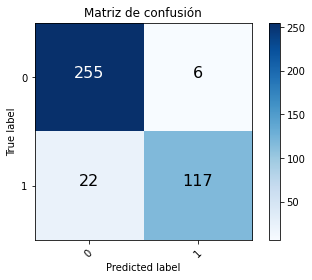

In [9]:
# 2

visualizar_confusion_matrix(y_test, modelo.predict(X_test))

Se observa que hay una mayor cantidad de Falsos negativos en comparación de los Falsos Positivos.

**CURVA DE ROC Y DE PRECISION-RECALL**

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


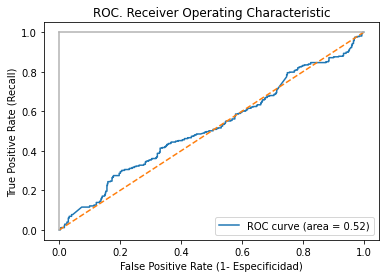

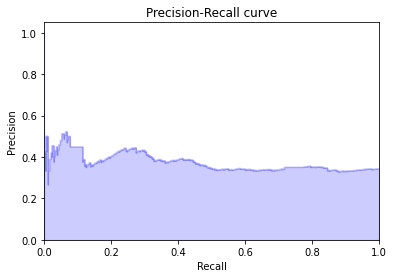

In [10]:
# 4

visualizar_curva_ROC(modelo, X, y)

Se observa un mal modelo que rnde en el 0.5 de área.

**FRONTERA DE DECISIÓN DE DOS DIMENSIONES**

No aplica para este caso por ser redes neuronales (#5).

La **curva logística** del punto #6 con la función AA_utils.visualizar_curva_logistica no aplica en este ejercicio debido a que el modelo cuenta con mas de una features en la variable X.

**FUNCION DE TRANSFERENCIA DE DOS DIMENSIONES**

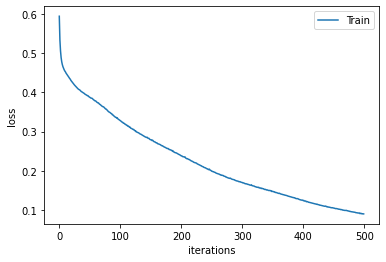

In [11]:
visualizar_curva_error_entrenamiento(modelo)

# **REGRESIÓN LOGÍSTICA**

**MODELADO**

In [12]:
modelo_2 = LogisticRegression()
modelo_2.fit(X_train, y_train)

LogisticRegression()

**EVALUACION**

**MÉTRICAS SOBRE EL CONJUNTO DE TRAINING**

In [13]:
# 3

print_classification_report(y_train, modelo_2.predict(X_train))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84      1055
           1       0.73      0.57      0.64       545

    accuracy                           0.78      1600
   macro avg       0.77      0.73      0.74      1600
weighted avg       0.78      0.78      0.77      1600



**MÉTRICAS SOBRE EL CONJUNTO DE TESTING**

In [14]:
# 3

print_classification_report(y_test, modelo_2.predict(X_test))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       261
           1       0.75      0.56      0.64       139

    accuracy                           0.78       400
   macro avg       0.77      0.73      0.74       400
weighted avg       0.78      0.78      0.77       400



**MATRIZ DE CONFUSIÓN**

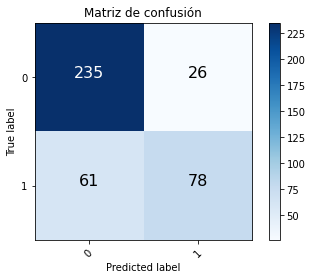

In [15]:
# 2

visualizar_confusion_matrix(y_test, modelo_2.predict(X_test))

**CURVA DE ROC Y DE PRECISION-RECALL**

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


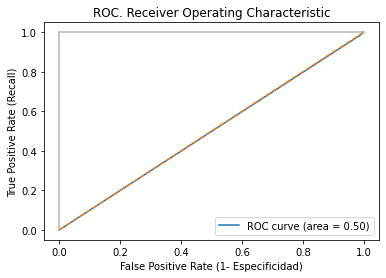

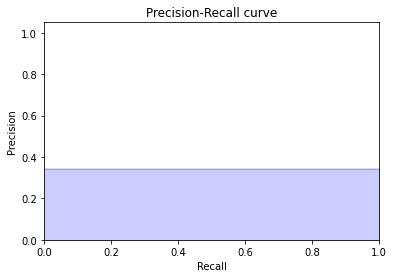

In [16]:
# 4

visualizar_curva_ROC(modelo_2, X, y)

Dado el área de la curva de ROC, se puede clasificar al **modelo como malo, similar al modelo de redes neuronales**.

**VISUALIZO LOS PARÁMETROS**

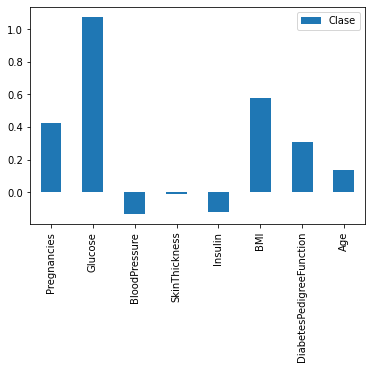

In [17]:
# 1

visualizar_parametros(modelo_2, mostrar_bias=False, feature_names=X.columns, target_name=y.name)

**FRONTERA DE DECISIÓN DE DOS DIMENSIONES**

No aplica para este caso (#5).

**FUNCION DE TRANSFERENCIA DE DOS DIMENSIONES**

No aplica para este caso (#5).

La **curva logística** del punto #6 con la función AA_utils.visualizar_curva_logistica no aplica en este ejercicio debido a que el modelo cuenta con mas de una features en la variable X.